In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
carpeta_tfm = '/content/drive/MyDrive/TFM'

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

El primer algoritmo que aplicaremos será una máquina de soporte vectorial

In [4]:
dades = pd.read_csv(carpeta_tfm + '/dermatology_clean.csv')
dades.head()

,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,...,disappearance_of_the_granular_layer,vacuolisation_and_damage_of_basal_layer,spongiosis,saw-tooth_appearance_of_retes,follicular_horn_plug,perifollicular_parakeratosis,inflammatory_monoluclear_inflitrate,band-like_infiltrate,age,class
0,2,2,0,3,0,0,0,0,1,0,...,0,0,3,0,0,0,1,0,55,2
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8,1
2,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,26,3
3,2,2,2,0,0,0,0,0,3,2,...,3,0,0,0,0,0,3,0,40,1
4,2,3,2,2,2,2,0,2,0,0,...,2,3,2,3,0,0,2,3,45,3


Primero de todo haremos un análisis exploratorio, para ver si existen correlaciones entre variables predictoras y correlaciones de las variables predictoras con la variable respuesta para saber si se puede reducir la dimensión del modelo.

In [5]:
# Análisis Exploratorio de Datos
# Estadísticas básicas
basic_stats = dades.describe()

# Los valores nulos ya han sido limpiados en la preparación de los datos, pero lo comprobaremos igualmente
missing_values = dades.isnull().sum()

# Análisis de balance de clases
class_balance = dades['class'].value_counts()

basic_stats, missing_values, class_balance


(         erythema     scaling  definite_borders     itching  \
 count  358.000000  358.000000        358.000000  358.000000   
 mean     2.078212    1.807263          1.569832    1.354749   
 std      0.664865    0.701541          0.900909    1.135062   
 min      0.000000    0.000000          0.000000    0.000000   
 25%      2.000000    1.000000          1.000000    0.000000   
 50%      2.000000    2.000000          2.000000    1.000000   
 75%      2.750000    2.000000          2.000000    2.000000   
 max      3.000000    3.000000          3.000000    3.000000   
 
        koebner_phenomenon  polygonal_papules  follicular_papules  \
 count          358.000000         358.000000          358.000000   
 mean             0.636872           0.449721            0.170391   
 std              0.908709           0.956468            0.576394   
 min              0.000000           0.000000            0.000000   
 25%              0.000000           0.000000            0.000000   
 50%    

Las estadisticas básicas no nos sirven de mucho, tenemos valores entre 0 y 3 en casi todas las variables excepto en la edad donde observamos una media de 36 años.

No encontramos valores faltantes.

En el balance de clases si que veoms que no estan balanceadas, sobre todo la clase 6 que tiene muchas menos instancias que las otras.

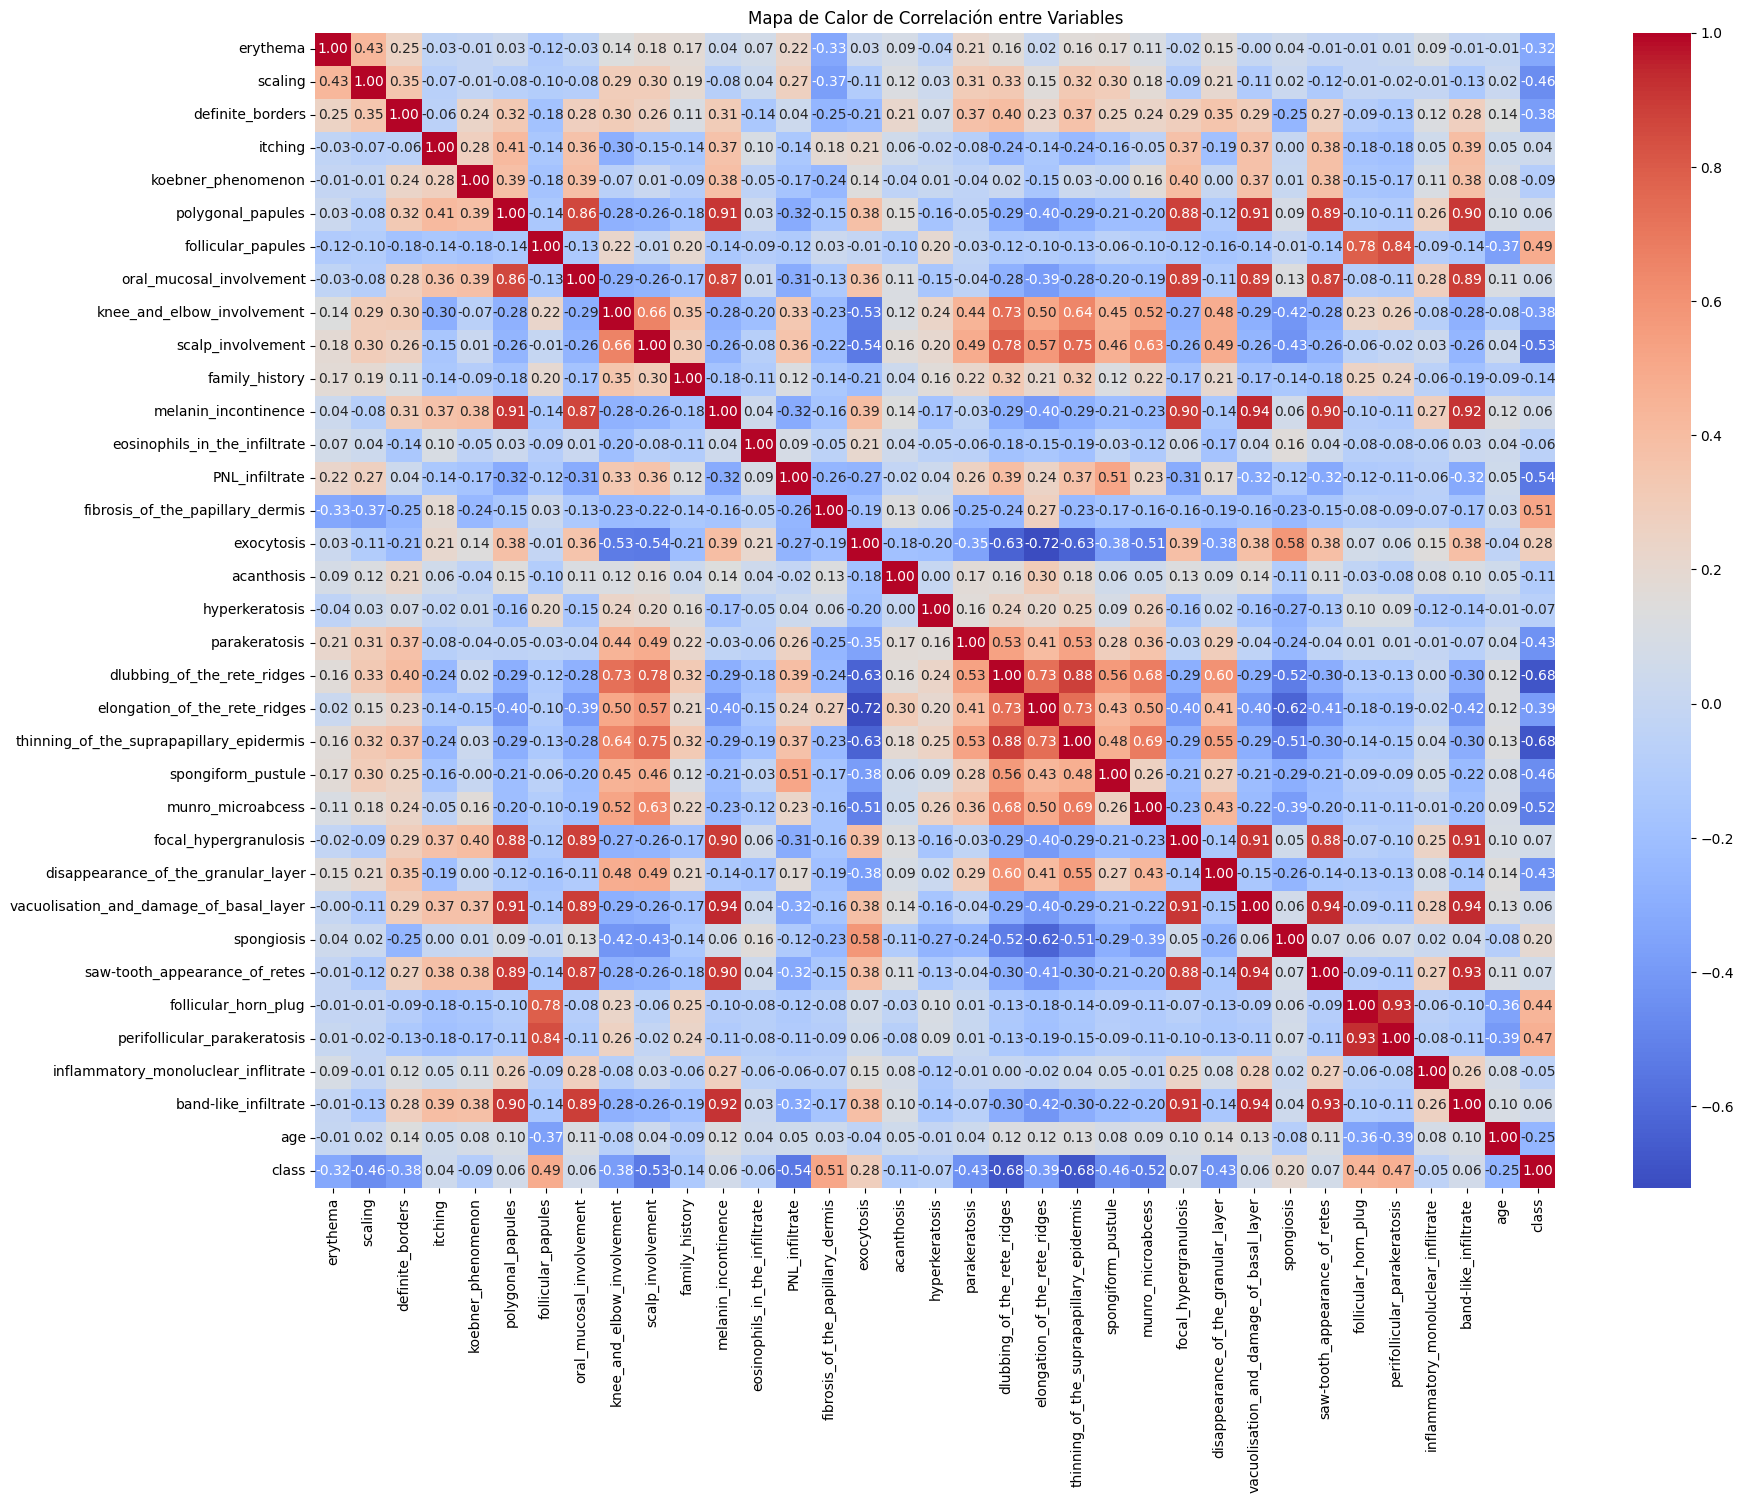

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# análisis de correloaciones
# matriz de correlación
correlation_matrix = dades.corr()

# mapa de calor para visualizar las correlaciones
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Mapa de Calor de Correlación entre Variables")
plt.show()


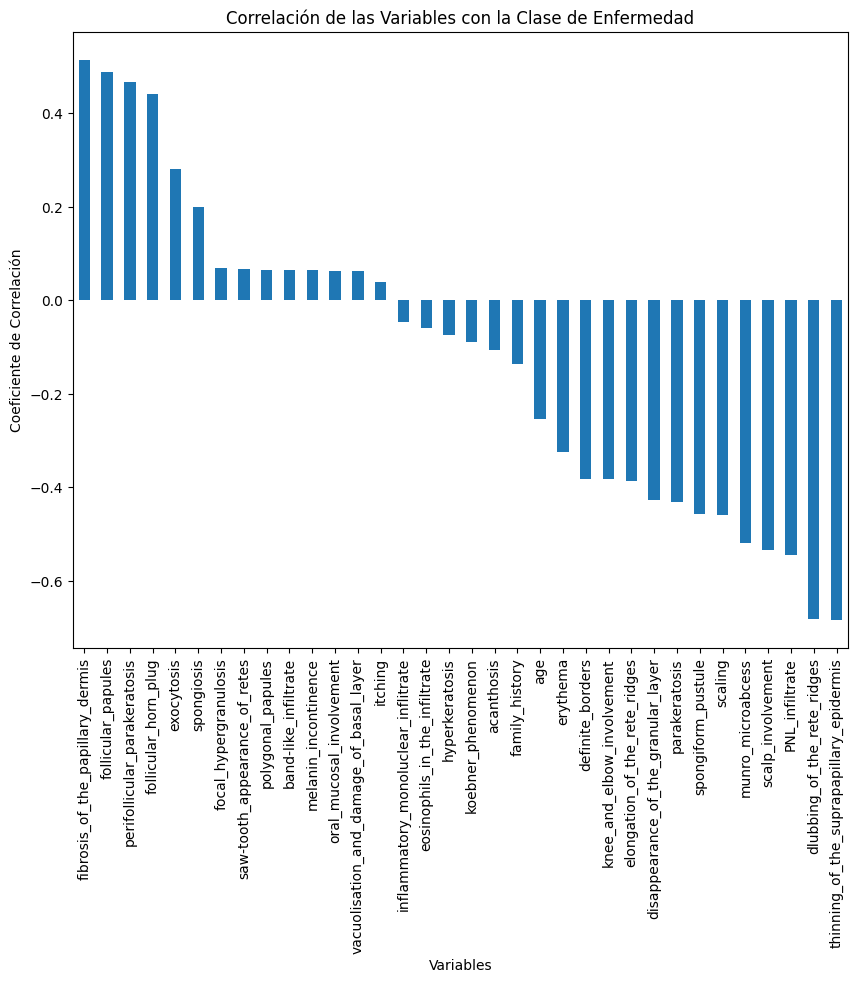

class                                       1.000000
fibrosis_of_the_papillary_dermis            0.514333
follicular_papules                          0.488708
perifollicular_parakeratosis                0.466687
follicular_horn_plug                        0.441210
exocytosis                                  0.280962
spongiosis                                  0.199351
focal_hypergranulosis                       0.070084
saw-tooth_appearance_of_retes               0.067255
polygonal_papules                           0.064451
band-like_infiltrate                        0.064356
melanin_incontinence                        0.064172
oral_mucosal_involvement                    0.062185
vacuolisation_and_damage_of_basal_layer     0.062153
itching                                     0.039744
inflammatory_monoluclear_inflitrate        -0.046707
eosinophils_in_the_infiltrate              -0.058692
hyperkeratosis                             -0.074791
koebner_phenomenon                         -0.

In [8]:
# correlación de las variables con la variable de respuesta (clase de enfermedad)
correlation_with_class = correlation_matrix['class'].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
correlation_with_class.drop('class').plot(kind='bar')
plt.title('Correlación de las Variables con la Clase de Enfermedad')
plt.ylabel('Coeficiente de Correlación')
plt.xlabel('Variables')
plt.show()

correlation_with_class


In [11]:
# balanceamos las clases
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = dades.drop('class', axis=1)
y = dades['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=93)

smote = SMOTE(random_state=93)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

y_train_smote.value_counts()

4    74
2    74
6    74
1    74
5    74
3    74
Name: class, dtype: int64

In [13]:
# estandarizamos
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

Vamos con el modelo SVM

In [67]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svm_model = SVC(kernel='linear', random_state=93)
svm_model.fit(X_train_smote_scaled, y_train_smote)
y_pred_svm = svm_model.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
classification_report_svm = classification_report(y_test, y_pred_svm)
confusion_matrix_svm = confusion_matrix(y_test, y_pred_svm)

print('SVM', accuracy_svm)
print(classification_report_svm)
print(confusion_matrix_svm)

SVM 0.9351851851851852
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        37
           2       0.78      0.90      0.84        20
           3       1.00      1.00      1.00        20
           4       0.82      0.64      0.72        14
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00         6

    accuracy                           0.94       108
   macro avg       0.93      0.92      0.93       108
weighted avg       0.94      0.94      0.93       108

[[37  0  0  0  0  0]
 [ 0 18  0  2  0  0]
 [ 0  0 20  0  0  0]
 [ 0  5  0  9  0  0]
 [ 0  0  0  0 11  0]
 [ 0  0  0  0  0  6]]


In [68]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train_smote_scaled, y_train_smote)
y_pred_nb = nb_model.predict(X_test_scaled)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
classification_report_nb = classification_report(y_test, y_pred_nb)
confusion_matrix_nb = confusion_matrix(y_test, y_pred_nb)

print('Maive Bayes', accuracy_nb)
print(classification_report_nb)
print(confusion_matrix_nb)

Maive Bayes 0.8333333333333334
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        37
           2       0.80      0.20      0.32        20
           3       1.00      1.00      1.00        20
           4       0.48      0.93      0.63        14
           5       0.83      0.91      0.87        11
           6       0.86      1.00      0.92         6

    accuracy                           0.83       108
   macro avg       0.83      0.84      0.79       108
weighted avg       0.87      0.83      0.81       108

[[37  0  0  0  0  0]
 [ 0  4  0 14  1  1]
 [ 0  0 20  0  0  0]
 [ 0  0  0 13  1  0]
 [ 0  1  0  0 10  0]
 [ 0  0  0  0  0  6]]


In [69]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=93)
dt_model.fit(X_train_smote_scaled, y_train_smote)
y_pred_dt = dt_model.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
classification_report_dt = classification_report(y_test, y_pred_dt)
confusion_matrix_dt = confusion_matrix(y_test, y_pred_dt)

print('Arboles de decisión', accuracy_dt)
print(classification_report_dt)
print(confusion_matrix_dt)

Arboles de decisión 0.9629629629629629
              precision    recall  f1-score   support

           1       1.00      0.97      0.99        37
           2       0.90      0.90      0.90        20
           3       1.00      1.00      1.00        20
           4       0.93      0.93      0.93        14
           5       1.00      1.00      1.00        11
           6       0.86      1.00      0.92         6

    accuracy                           0.96       108
   macro avg       0.95      0.97      0.96       108
weighted avg       0.96      0.96      0.96       108

[[36  1  0  0  0  0]
 [ 0 18  0  1  0  1]
 [ 0  0 20  0  0  0]
 [ 0  1  0 13  0  0]
 [ 0  0  0  0 11  0]
 [ 0  0  0  0  0  6]]


In [70]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_smote_scaled, y_train_smote)
y_pred_knn = knn_model.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
classification_report_knn = classification_report(y_test, y_pred_knn)
confusion_matrix_knn = confusion_matrix(y_test, y_pred_knn)

print('KNN', accuracy_knn)
print(classification_report_knn)
print(confusion_matrix_knn)

KNN 0.9629629629629629
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        37
           2       0.94      0.85      0.89        20
           3       1.00      1.00      1.00        20
           4       0.81      0.93      0.87        14
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00         6

    accuracy                           0.96       108
   macro avg       0.96      0.96      0.96       108
weighted avg       0.97      0.96      0.96       108

[[37  0  0  0  0  0]
 [ 0 17  0  3  0  0]
 [ 0  0 20  0  0  0]
 [ 0  1  0 13  0  0]
 [ 0  0  0  0 11  0]
 [ 0  0  0  0  0  6]]


In [71]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000, random_state=93, multi_class='multinomial', solver='lbfgs')
lr_model.fit(X_train_smote_scaled, y_train_smote)
y_pred_lr = lr_model.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
classification_report_lr = classification_report(y_test, y_pred_lr)
confusion_matrix_lr = confusion_matrix(y_test, y_pred_lr)

print('Regresion logistica', accuracy_lr)
print(classification_report_lr)
print(confusion_matrix_lr)

Regresion logistica 0.9444444444444444
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        37
           2       0.82      0.90      0.86        20
           3       1.00      1.00      1.00        20
           4       0.83      0.71      0.77        14
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00         6

    accuracy                           0.94       108
   macro avg       0.94      0.94      0.94       108
weighted avg       0.94      0.94      0.94       108

[[37  0  0  0  0  0]
 [ 0 18  0  2  0  0]
 [ 0  0 20  0  0  0]
 [ 0  4  0 10  0  0]
 [ 0  0  0  0 11  0]
 [ 0  0  0  0  0  6]]


In [72]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=93)
gb_model.fit(X_train_smote_scaled, y_train_smote)
y_pred_gb = gb_model.predict(X_test_scaled)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
classification_report_gb = classification_report(y_test, y_pred_gb)
confusion_matrix_gb = confusion_matrix(y_test, y_pred_gb)
print('Gradient Boost', accuracy_gb)
print(classification_report_gb)
print(confusion_matrix_gb)


Gradient Boost 0.9351851851851852
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        37
           2       0.84      0.80      0.82        20
           3       1.00      0.95      0.97        20
           4       0.80      0.86      0.83        14
           5       1.00      1.00      1.00        11
           6       0.86      1.00      0.92         6

    accuracy                           0.94       108
   macro avg       0.92      0.93      0.92       108
weighted avg       0.94      0.94      0.94       108

[[37  0  0  0  0  0]
 [ 0 16  0  3  0  1]
 [ 0  1 19  0  0  0]
 [ 0  2  0 12  0  0]
 [ 0  0  0  0 11  0]
 [ 0  0  0  0  0  6]]


Epoch 1/70
12/12 [==============================] - 4s 88ms/step - loss: 1.4311 - accuracy: 0.5296 - val_loss: 1.4642 - val_accuracy: 0.3596
Epoch 2/70
12/12 [==============================] - 0s 22ms/step - loss: 0.7662 - accuracy: 0.8056 - val_loss: 1.2276 - val_accuracy: 0.4157
Epoch 3/70
12/12 [==============================] - 1s 49ms/step - loss: 0.3950 - accuracy: 0.9099 - val_loss: 0.8503 - val_accuracy: 0.8539
Epoch 4/70
12/12 [==============================] - 1s 46ms/step - loss: 0.2155 - accuracy: 0.9606 - val_loss: 0.3220 - val_accuracy: 0.9551
Epoch 5/70
12/12 [==============================] - 0s 41ms/step - loss: 0.1228 - accuracy: 0.9634 - val_loss: 0.1274 - val_accuracy: 1.0000
Epoch 6/70
12/12 [==============================] - 0s 21ms/step - loss: 0.0865 - accuracy: 0.9775 - val_loss: 0.0595 - val_accuracy: 1.0000
Epoch 7/70
12/12 [==============================] - 0s 11ms/step - loss: 0.0807 - accuracy: 0.9718 - val_loss: 0.0387 - val_accuracy: 1.0000
Epoch 8/70
12

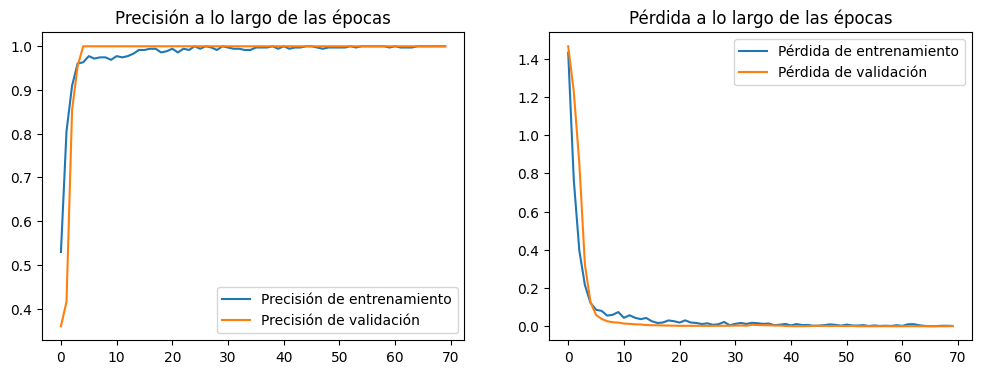

In [134]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

y_train_smote_adjusted = y_train_smote - 1
y_test_adjusted = y_test - 1

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_smote_scaled.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history = model.fit(X_train_smote_scaled, y_train_smote_adjusted, epochs=70, batch_size=32, validation_split=0.2)

y_pred_nn = model.predict(X_test_scaled)
y_pred_nn_classes = tf.argmax(y_pred_nn, axis=1).numpy()

accuracy_nn = accuracy_score(y_test_adjusted, y_pred_nn_classes)
classification_report_nn = classification_report(y_test_adjusted, y_pred_nn_classes)
confusion_matrix_nn = confusion_matrix(y_test_adjusted, y_pred_nn_classes)
print("Red Neuronal Profunda - Precisión:", accuracy_nn)
print("Informe de Clasificación:\n", classification_report_nn)
print("Matriz de Confusión:\n", confusion_matrix_nn)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión a lo largo de las épocas')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida a lo largo de las épocas')
plt.legend()
plt.show()


Ajustes de hiperparametros para cada modelo y ver si podemos mejorarlos. Solo en los modelos que se ha obtenido valores altos de precisión.

In [91]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

pipeline = Pipeline([
    ('smote', SMOTE(random_state=93)),
    ('classifier', SVC(random_state=93))
])


param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'sigmoid']
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación:", grid_search.best_score_)



Mejores parámetros: {'classifier__C': 10, 'classifier__kernel': 'linear'}
Mejor puntuación: 0.9691705790297339


In [109]:

optimized_svm_model = SVC(C=0.05, kernel='linear', random_state=93)
optimized_svm_model.fit(X_train_smote_scaled, y_train_smote)

y_pred_optimized_svm = optimized_svm_model.predict(X_test_scaled)
accuracy_optimized_svm = accuracy_score(y_test, y_pred_optimized_svm)
classification_report_optimized_svm = classification_report(y_test, y_pred_optimized_svm)
confusion_matrix_optimized_svm = confusion_matrix(y_test, y_pred_optimized_svm)
print('Optimized SVM Accuracy:', accuracy_optimized_svm)
print('Classification Report:\n', classification_report_optimized_svm)
print('Confusion Matrix:\n', confusion_matrix_optimized_svm)


Optimized SVM Accuracy: 0.9537037037037037
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        37
           2       0.83      0.95      0.88        20
           3       1.00      1.00      1.00        20
           4       0.91      0.71      0.80        14
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00         6

    accuracy                           0.95       108
   macro avg       0.96      0.94      0.95       108
weighted avg       0.96      0.95      0.95       108

Confusion Matrix:
 [[37  0  0  0  0  0]
 [ 0 19  0  1  0  0]
 [ 0  0 20  0  0  0]
 [ 0  4  0 10  0  0]
 [ 0  0  0  0 11  0]
 [ 0  0  0  0  0  6]]


In [113]:
from sklearn.tree import DecisionTreeClassifier

param_grid_dt = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

grid_search_dt = GridSearchCV(Pipeline([('classifier', DecisionTreeClassifier(random_state=93))]), param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train_smote_scaled, y_train_smote)
print("Decision Tree - Mejores parámetros:", grid_search_dt.best_params_)
print("Mejor puntuación:", grid_search_dt.best_score_)


Decision Tree - Mejores parámetros: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_split': 2}
Mejor puntuación: 0.9774770173646579


In [118]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=93)
dt_model.fit(X_train_smote_scaled, y_train_smote)
y_pred_dt = dt_model.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
classification_report_dt = classification_report(y_test, y_pred_dt)
confusion_matrix_dt = confusion_matrix(y_test, y_pred_dt)

print('Arboles de decisión', accuracy_dt)
print(classification_report_dt)
print(confusion_matrix_dt)

Arboles de decisión 0.9629629629629629
              precision    recall  f1-score   support

           1       1.00      0.97      0.99        37
           2       0.90      0.90      0.90        20
           3       1.00      1.00      1.00        20
           4       0.93      0.93      0.93        14
           5       1.00      1.00      1.00        11
           6       0.86      1.00      0.92         6

    accuracy                           0.96       108
   macro avg       0.95      0.97      0.96       108
weighted avg       0.96      0.96      0.96       108

[[36  1  0  0  0  0]
 [ 0 18  0  1  0  1]
 [ 0  0 20  0  0  0]
 [ 0  1  0 13  0  0]
 [ 0  0  0  0 11  0]
 [ 0  0  0  0  0  6]]


In [114]:
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 10],
    'classifier__weights': ['uniform', 'distance']
}

grid_search_knn = GridSearchCV(Pipeline([('classifier', KNeighborsClassifier())]), param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train_smote_scaled, y_train_smote)
print("KNN - Mejores parámetros:", grid_search_knn.best_params_)
print("Mejor puntuación:", grid_search_knn.best_score_)

KNN - Mejores parámetros: {'classifier__n_neighbors': 10, 'classifier__weights': 'distance'}
Mejor puntuación: 0.9639683350357509


In [117]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_smote_scaled, y_train_smote)
y_pred_knn = knn_model.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
classification_report_knn = classification_report(y_test, y_pred_knn)
confusion_matrix_knn = confusion_matrix(y_test, y_pred_knn)

print('KNN', accuracy_knn)
print(classification_report_knn)
print(confusion_matrix_knn)

KNN 0.9629629629629629
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        37
           2       0.94      0.85      0.89        20
           3       1.00      1.00      1.00        20
           4       0.81      0.93      0.87        14
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00         6

    accuracy                           0.96       108
   macro avg       0.96      0.96      0.96       108
weighted avg       0.97      0.96      0.96       108

[[37  0  0  0  0  0]
 [ 0 17  0  3  0  0]
 [ 0  0 20  0  0  0]
 [ 0  1  0 13  0  0]
 [ 0  0  0  0 11  0]
 [ 0  0  0  0  0  6]]


In [116]:
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2', 'none']
}

grid_search_lr = GridSearchCV(Pipeline([('classifier', LogisticRegression(max_iter=1000, random_state=93))]), param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train_smote_scaled, y_train_smote)
print("Logistic Regression - Mejores parámetros:", grid_search_lr.best_params_)
print("Mejor puntuación:", grid_search_lr.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour

Logistic Regression - Mejores parámetros: {'classifier__C': 1, 'classifier__penalty': 'l2'}
Mejor puntuación: 0.9820224719101123


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour

In [132]:
lr_model_2 = LogisticRegression(C=0.01, penalty='l2', max_iter=1000, random_state=93, multi_class='multinomial', solver='lbfgs')
lr_model_2.fit(X_train_smote_scaled, y_train_smote)
y_pred_lr_2 = lr_model_2.predict(X_test_scaled)
accuracy_lr_2 = accuracy_score(y_test, y_pred_lr_2)
classification_report_lr_2 = classification_report(y_test, y_pred_lr_2)
confusion_matrix_lr_2 = confusion_matrix(y_test, y_pred_lr_2)

print('Regresion logistica', accuracy_lr_2)
print(classification_report_lr_2)
print(confusion_matrix_lr_2)

Regresion logistica 0.9629629629629629
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        37
           2       0.86      0.95      0.90        20
           3       1.00      1.00      1.00        20
           4       0.92      0.79      0.85        14
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00         6

    accuracy                           0.96       108
   macro avg       0.96      0.96      0.96       108
weighted avg       0.96      0.96      0.96       108

[[37  0  0  0  0  0]
 [ 0 19  0  1  0  0]
 [ 0  0 20  0  0  0]
 [ 0  3  0 11  0  0]
 [ 0  0  0  0 11  0]
 [ 0  0  0  0  0  6]]


In [137]:
from joblib import dump, load

# Guardar el modelo entrenado en un archivo
dump(optimized_svm_model, 'optimized_svm_model.joblib')

['optimized_svm_model.joblib']

In [139]:

scaler = StandardScaler().fit(X_train_smote)
dump(scaler, 'scaler.joblib')

['scaler.joblib']